# Preprocess the data for applying LSTM-based approach proposed by Rieger et al. (2023)

Rieger, Laura Hannemose, et al. “Uncertainty-Aware and Explainable Machine Learning for Early Prediction of Battery Degradation Trajectory.” Digital Discovery, vol. 2, no. 1, 2023, pp. 112–22. DOI: https://doi.org/10.1039/D2DD00067A.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import pchip_interpolate
from sklearn.preprocessing import StandardScaler

import pickle


Import the dataset

In [2]:
# Load the data with only valid cells
nmc_data = pd.read_csv('../Data_preprocessing/NMC_data.csv')
training_cells = pd.read_csv("../Data_preprocessing/training.csv",header=None).to_numpy(dtype=str).reshape(-1,).tolist()
test_in_cells = pd.read_csv("../Data_preprocessing/test_in.csv",header=None).to_numpy(dtype=str).reshape(-1,).tolist()
test_out_cells = pd.read_csv("../Data_preprocessing/test_out.csv",header=None).to_numpy(dtype=str).reshape(-1,).tolist()

# Import preprocessed PCA feature table
train_features = np.loadtxt('../Main_study/Processed_input_output/X_train_PCA.csv',delimiter=",")
test_in_features = np.loadtxt('../Main_study/Processed_input_output/X_test_in_PCA.csv',delimiter=",")
test_out_features = np.loadtxt('../Main_study/Processed_input_output/X_test_out_PCA.csv',delimiter=",")

# Interpolate the trajectories to be equidistant along Ah-throughput axis

In [7]:
# Interplation of trajectory
interp_step = 5 # every 5 Ah

# training cells
trajectory_train_interp = {}
ah_throughput_3weeks_train = []
for cell in training_cells:
    cell_data = nmc_data[nmc_data['cellID']==cell]
    # max_ah = np.ceil(cell_data['Ah_throughput'].iloc[-1])
    # Ah-throughput vs capacity
    x_raw = cell_data['Ah_throughput'].to_numpy()
    y_raw = cell_data['qdis'].to_numpy()
    # Find the index of the first RPT below 80% remaining capacity
    idx_80 = np.where(y_raw<=0.8)[0][0]
    max_ah = np.ceil(x_raw[idx_80])
    # Interpolation points
    x_interp = np.arange(0,max_ah,interp_step)

    # Interpolate the data
    y_interp = pchip_interpolate(x_raw,y_raw,x_interp)

    trajectory_train_interp[cell] = (x_interp,y_interp)

    # Find the Ah-throughput after 3 weeks of cycling
    group = int(cell[1:-2])
    if group<20:
        ah_throughput_3weeks_train.append(np.round(cell_data['Ah_throughput'].iloc[3],0))
    else:
        ah_throughput_3weeks_train.append(np.round(cell_data['Ah_throughput'].iloc[4],0))

# test_in cells
trajectory_test_in_interp = {}
ah_throughput_3weeks_test_in = []
for cell in test_in_cells:
    cell_data = nmc_data[nmc_data['cellID']==cell]
    # Ah-throughput vs capacity
    x_raw = cell_data['Ah_throughput'].to_numpy()
    y_raw = cell_data['qdis'].to_numpy()
    # Find the index of the first RPT below 80% remaining capacity
    idx_80 = np.where(y_raw<=0.8)[0][0]
    max_ah = np.ceil(x_raw[idx_80])
    # Interpolation points
    x_interp = np.arange(0,max_ah,interp_step)

    # Interpolate the data
    y_interp = pchip_interpolate(x_raw,y_raw,x_interp)

    trajectory_test_in_interp[cell] = (x_interp,y_interp)

    # Find the Ah-throughput after 3 weeks of cycling
    group = int(cell[1:-2])
    if group<20:
        ah_throughput_3weeks_test_in.append(np.round(cell_data['Ah_throughput'].iloc[3],0))
    else:
        ah_throughput_3weeks_test_in.append(np.round(cell_data['Ah_throughput'].iloc[4],0))


# test_out cells
trajectory_test_out_interp = {}
ah_throughput_3weeks_test_out = []
for cell in test_out_cells:
    cell_data = nmc_data[nmc_data['cellID']==cell]
    # Ah-throughput vs capacity
    x_raw = cell_data['Ah_throughput'].to_numpy()
    y_raw = cell_data['qdis'].to_numpy()
    # Find the index of the first RPT below 80% remaining capacity
    idx_80 = np.where(y_raw<=0.8)[0][0]
    max_week = np.ceil(x_raw[idx_80])
    # Interpolation points
    x_interp = np.arange(0,max_week,interp_step)

    # Interpolate the data
    y_interp = pchip_interpolate(x_raw,y_raw,x_interp)

    trajectory_test_out_interp[cell] = (x_interp,y_interp)

    # Find the Ah-throughput after 3 weeks of cycling
    group = int(cell[1:-2])
    if group<20:
        ah_throughput_3weeks_test_out.append(np.round(cell_data['Ah_throughput'].iloc[3],0))
    else:
        ah_throughput_3weeks_test_out.append(np.round(cell_data['Ah_throughput'].iloc[4],0))


In [ ]:
# Dump the interpolated trajectories
with open('Data/trajectory_train_interp.pkl', 'wb') as f:
    pickle.dump(trajectory_train_interp, f)

with open('Data/trajectory_test_in_interp.pkl', 'wb') as f:
    pickle.dump(trajectory_test_in_interp, f)

with open('Data/trajectory_test_out_interp.pkl', 'wb') as f:
    pickle.dump(trajectory_test_out_interp, f)

# Dump the Ah-throughput after 3 weeks of cycling
np.savetxt('Data/ah_throughput_3weeks_train.csv',ah_throughput_3weeks_train,delimiter=",")
np.savetxt('Data/ah_throughput_3weeks_test_in.csv',ah_throughput_3weeks_test_in,delimiter=",")
np.savetxt('Data/ah_throughput_3weeks_test_out.csv',ah_throughput_3weeks_test_out,delimiter=",")

# Process the input-output pairs for training LSTM

Process the training samples

In [ ]:
# There are three sets of data needed to be saved
# x: sequence of trajectory (num_samples,sequence_length,1)
# y: ratio between capacity at t+1 and t, and time to EOL (num_samples,2)
# c: 10 early-life PCA features and log(ah-throughput) (num_samples,11) 

sequence_length = 10

train_X_lstm = []
train_Y_lstm = []
train_C_lstm = []

train_cell_lstm = []

train_X_lstm_eval = []
train_C_lstm_eval = {}
train_remaining_eval = {}

for iii,cell in enumerate(training_cells):
    ah = trajectory_train_interp[cell][0]

    Q = trajectory_train_interp[cell][1]
    feature = train_features[iii]

    # Ah-throughput cutoff at week 3
    cutoff = ah_throughput_3weeks_train[iii]
    cutoff_idx = np.argmin(np.abs(ah-cutoff))

    train_X_lstm_eval.append(Q[cutoff_idx+1-sequence_length:cutoff_idx+1].reshape(-1,1))

    train_remaining_eval[cell]=Q[cutoff_idx+1:]
    train_C_lstm_eval[cell] = []
    for i in range(cutoff_idx+1,len(Q)):
        # i-1 is the last index of the sequence
        # i is the index for prediction
        x = Q[i-sequence_length:i].reshape(-1,1)
        # y_ = ah[i-sequence_length:i]
        y = Q[i]/Q[i-1]
        y1 = ah[-1]-ah[i-1]
        c = np.append(feature,np.log(ah[i-1]))

        train_X_lstm.append(x)
        train_Y_lstm.append([y,y1])
        train_C_lstm.append(c)
        train_cell_lstm.append(cell)

        train_C_lstm_eval[cell].append(c)

    if len(train_C_lstm_eval[cell])!=len(train_remaining_eval[cell]):
        print('Error')
        break



train_X_lstm = np.array(train_X_lstm)
train_Y_lstm = np.array(train_Y_lstm)
train_C_lstm = np.array(train_C_lstm)

scaler_log_ah = StandardScaler()
train_C_lstm[:,-1] = scaler_log_ah.fit_transform(train_C_lstm[:,-1].reshape(-1,1)).reshape(-1)

# Save the data
np.save('Data/train_X_lstm.npy',train_X_lstm)
np.save('Data/train_Y_lstm.npy',train_Y_lstm)
np.save('Data/train_C_lstm.npy',train_C_lstm)

train_X_lstm_eval = np.array(train_X_lstm_eval)
for cell in train_C_lstm_eval.keys():
    train_C_lstm_eval[cell] = np.array(train_C_lstm_eval[cell])
    train_C_lstm_eval[cell][:,-1] = scaler_log_ah.transform(train_C_lstm_eval[cell][:,-1].reshape(-1,1)).reshape(-1)

# Save the evaluation data
np.save('Data/train_X_lstm_eval.npy',train_X_lstm_eval)

# Save the remaining capacity and PCA features
with open('Data/train_remaining_eval.pkl', 'wb') as f:
    pickle.dump(train_remaining_eval, f)

with open('Data/train_C_lstm_eval.pkl', 'wb') as f:
    pickle.dump(train_C_lstm_eval, f)

with open('Data/train_cell_lstm.pkl', 'wb') as f:
    pickle.dump(train_cell_lstm, f)

Process for both test sets

In [ ]:
# Test-in data
test_in_X_lstm_eval = []
test_in_C_lstm_eval = {}
test_in_remaining_eval = {}
for iii,cell in enumerate(test_in_cells):
    ah = trajectory_test_in_interp[cell][0]

    Q = trajectory_test_in_interp[cell][1]
    feature = test_in_features[iii]

    # Ah-throughput cutoff at week 3
    cutoff = ah_throughput_3weeks_test_in[iii]
    cutoff_idx = np.argmin(np.abs(ah-cutoff))

    test_in_X_lstm_eval.append(Q[cutoff_idx+1-sequence_length:cutoff_idx+1].reshape(-1,1))
    test_in_remaining_eval[cell]=Q[cutoff_idx+1:]

    test_in_C_lstm_eval[cell] = []
    for i in range(cutoff_idx+1,len(Q)):
        # i-1 is the last index of the sequence
        # i is the index for prediction
        x = Q[i-sequence_length:i].reshape(-1,1)
        # y_ = ah[i-sequence_length:i]
        y = Q[i]/Q[i-1]
        y1 = ah[-1]-ah[i-1]
        c = np.append(feature,np.log(ah[i-1]))
        test_in_C_lstm_eval[cell].append(c)

test_in_X_lstm_eval = np.array(test_in_X_lstm_eval)

for cell in test_in_C_lstm_eval.keys():
    test_in_C_lstm_eval[cell] = np.array(test_in_C_lstm_eval[cell])
    test_in_C_lstm_eval[cell][:,-1] = scaler_log_ah.transform(test_in_C_lstm_eval[cell][:,-1].reshape(-1,1)).reshape(-1)

np.save('Data/test_in_X_lstm_eval.npy',test_in_X_lstm_eval)
with open('Data/test_in_remaining_eval.pkl', 'wb') as f:
    pickle.dump(test_in_remaining_eval, f)

with open('Data/test_in_C_lstm_eval.pkl', 'wb') as f:
    pickle.dump(test_in_C_lstm_eval, f)

# Test-out data
test_out_X_lstm_eval = []
test_out_C_lstm_eval = {}
test_out_remaining_eval = {}

for iii,cell in enumerate(test_out_cells):
    ah = trajectory_test_out_interp[cell][0]

    Q = trajectory_test_out_interp[cell][1]
    feature = test_out_features[iii]

    # Ah-throughput cutoff at week 3
    cutoff = ah_throughput_3weeks_test_out[iii]
    cutoff_idx = np.argmin(np.abs(ah-cutoff))
    test_out_X_lstm_eval.append(Q[cutoff_idx+1-sequence_length:cutoff_idx+1].reshape(-1,1))
    test_out_remaining_eval[cell]=Q[cutoff_idx+1:]

    test_out_C_lstm_eval[cell] = []
    for i in range(cutoff_idx+1,len(Q)):
        # i-1 is the last index of the sequence
        # i is the index for prediction
        x = Q[i-sequence_length:i].reshape(-1,1)
        # y_ = ah[i-sequence_length:i]
        y = Q[i]/Q[i-1]
        y1 = ah[-1]-ah[i-1]
        c = np.append(feature,np.log(ah[i-1]))
        test_out_C_lstm_eval[cell].append(c)

test_out_X_lstm_eval = np.array(test_out_X_lstm_eval)

for cell in test_out_C_lstm_eval.keys():
    test_out_C_lstm_eval[cell] = np.array(test_out_C_lstm_eval[cell])
    test_out_C_lstm_eval[cell][:,-1] = scaler_log_ah.transform(test_out_C_lstm_eval[cell][:,-1].reshape(-1,1)).reshape(-1)

np.save('Data/test_out_X_lstm_eval.npy',test_out_X_lstm_eval)
with open('Data/test_out_remaining_eval.pkl', 'wb') as f:
    pickle.dump(test_out_remaining_eval, f)

with open('Data/test_out_C_lstm_eval.pkl', 'wb') as f:
    pickle.dump(test_out_C_lstm_eval, f)

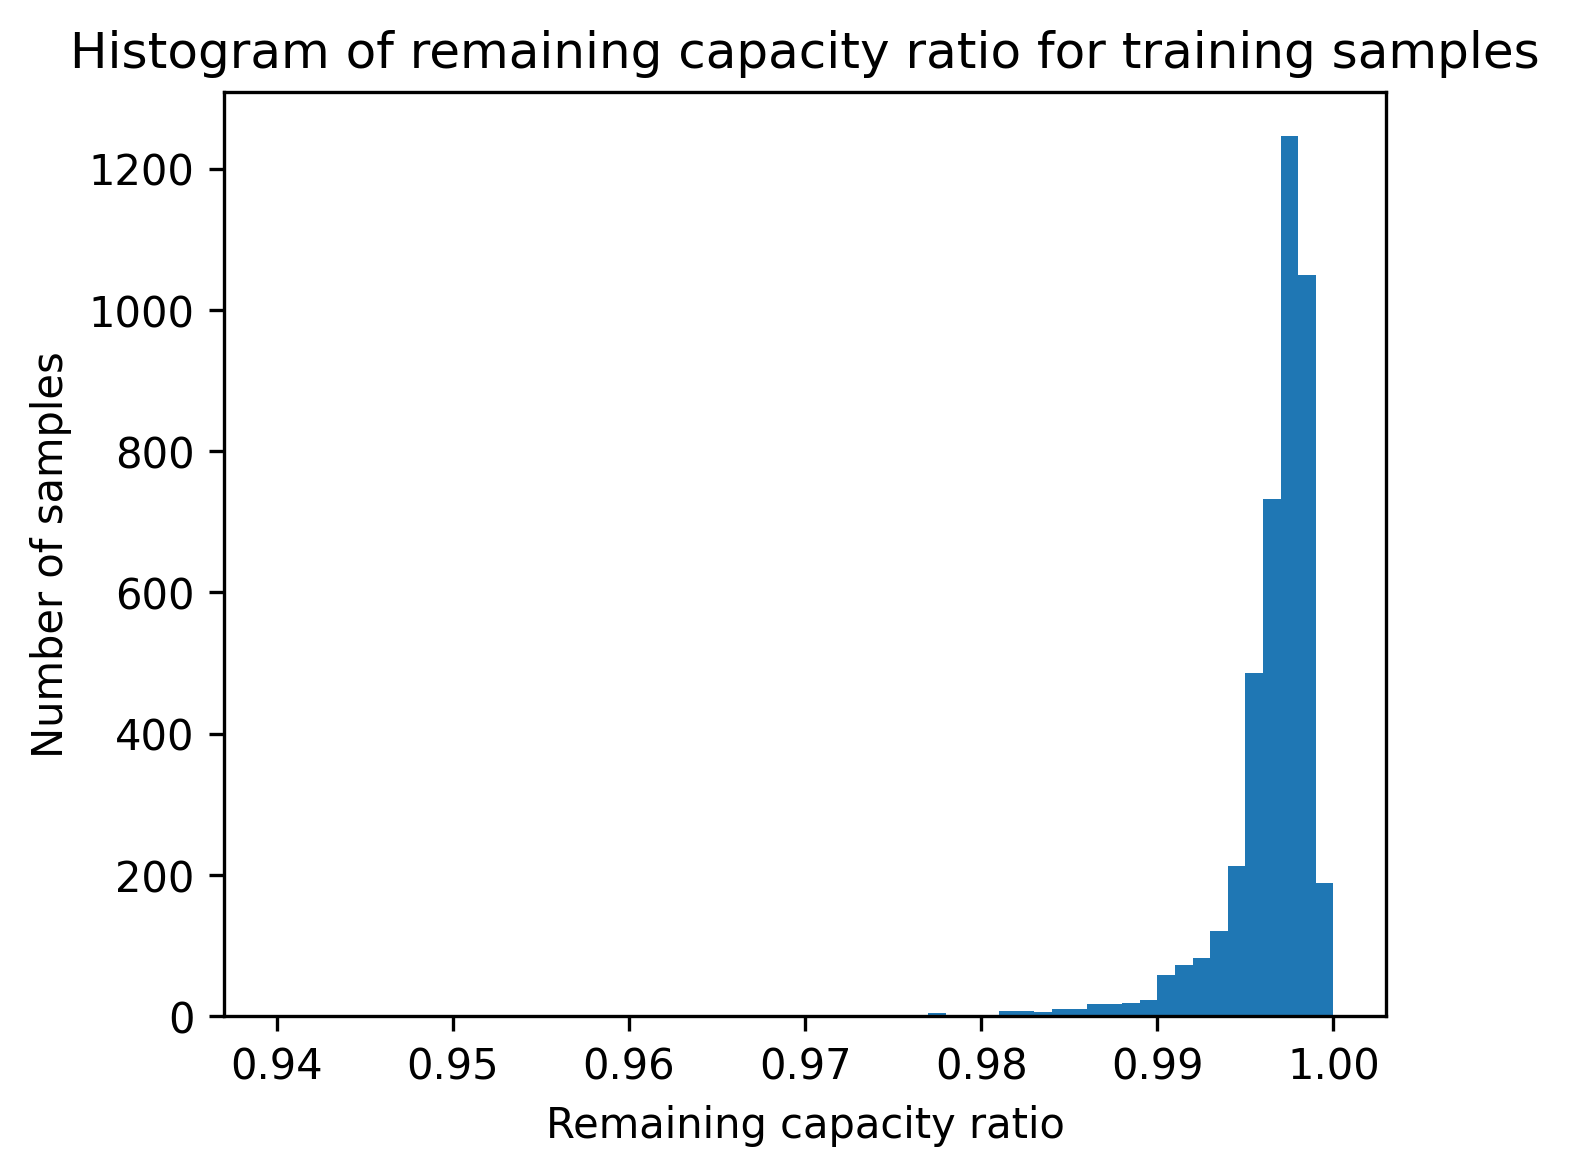

In [12]:
bins = np.arange(0.94,1,0.001)
plt.figure(figsize=(5,4),dpi=300)
plt.hist(train_Y_lstm[:,0],bins=bins)
plt.xlabel('Remaining capacity ratio')
plt.ylabel('Number of samples')
plt.title('Histogram of remaining capacity ratio for training samples')
plt.show()

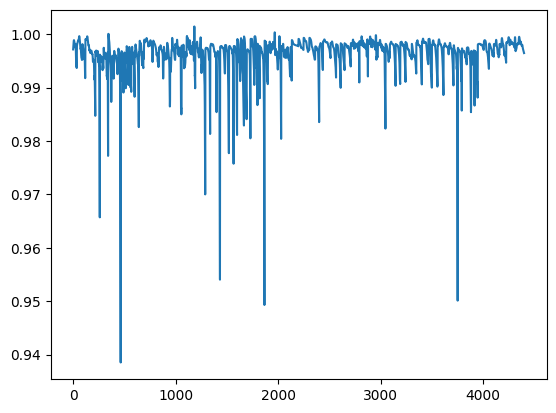

In [13]:
plt.plot(train_Y_lstm[:,0])